In [1]:

import numpy as np
import pandas as pd 
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

# Пути к файлам

In [2]:

train_path = "/kaggle/input/equity-post-HCT-survival-predictions/train.csv"
test_path = "/kaggle/input/equity-post-HCT-survival-predictions/test.csv"
submission_path = "/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv"

# Загрузка данных

In [3]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [4]:
RMV = ["ID","efs","efs_time"]
FEATURES = [c for c in train_data.columns if not c in RMV]
print(f"Здесь {len(FEATURES)} Фичей: {FEATURES}")

Здесь 57 Фичей: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno

def comprehensive_eda(df, target_col='efs'):
    plt.style.use('seaborn')
    
    def print_separator():
        print("\n" + "="*50 + "\n")
    
    # 1. Общая информация о датасете
    print("ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ:")
    print(f"Размер датасета: {df.shape}")
    print("\nТипы данных:")
    print(df.dtypes)
    print_separator()
    
   
    
    # 3. Статистический анализ числовых признаков
    print("СТАТИСТИЧЕСКИЙ АНАЛИЗ ЧИСЛОВЫХ ПРИЗНАКОВ:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(df[numeric_cols].describe())
    
    # Визуализация распределений числовых признаков
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_cols):
        sns.histplot(data=df, x=col, ax=axes[idx], kde=True)
        axes[idx].set_title(f'Распределение {col}')
    
    plt.tight_layout()
    plt.show()
    print_separator()
    
    # 4. Анализ категориальных признаков
    print("АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        print(f"\nРаспределение значений в столбце {col}:")
        value_counts = df[col].value_counts()
        print(value_counts)
        
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, y=col, order=value_counts.index)
        plt.title(f'Распределение значений {col}')
        plt.show()
    print_separator()
    
    # 5. Корреляционный анализ
    print("КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:")
    correlation_matrix = df[numeric_cols].corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Корреляционная матрица числовых признаков')
    plt.show()
    print_separator()
    
    # 6. Анализ целевой переменной
    if target_col in df.columns:
        print("АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
        print("\nСтатистика целевой переменной:")
        print(df[target_col].describe())
        
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x=target_col, kde=True)
        plt.title(f'Распределение целевой переменной {target_col}')
        plt.show()
        
        # Зависимость целевой переменной от числовых признаков
        for col in numeric_cols:
            if col != target_col:
                plt.figure(figsize=(10, 6))
                sns.scatterplot(data=df, x=col, y=target_col)
                plt.title(f'Зависимость {target_col} от {col}')
                plt.show()
        
        # Зависимость целевой переменной от категориальных признаков
        for col in categorical_cols:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=df, x=col, y=target_col)
            plt.xticks(rotation=45)
            plt.title(f'Распределение {target_col} по категориям {col}')
            plt.show()
    print_separator()
    
    # 7. Анализ выбросов для числовых признаков
    print("АНАЛИЗ ВЫБРОСОВ:")
    plt.figure(figsize=(15, 6))
    df[numeric_cols].boxplot()
    plt.xticks(rotation=45)
    plt.title('Диаграммы размаха для числовых признаков')
    plt.show()
    
    # Расчет z-score для определения выбросов
    z_scores = {}
    for col in numeric_cols:
        z_scores[col] = np.abs(stats.zscore(df[col].dropna()))
        outliers = (z_scores[col] > 3).sum()
        print(f"Количество выбросов в {col}: {outliers} (z-score > 3)")
    print_separator()

# Использование функции
comprehensive_eda(train_data)

In [ ]:
# Анализ HCT-CI score
def analyze_hct_ci(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='hct_ci_score', bins=20)
    plt.title('Распределение HCT-CI Score')
    plt.show()
    
    # Зависимость целевой переменной от HCT-CI score
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='ci_score_danger', y='efs')
    plt.title('Зависимость выживаемости от уровня риска HCT-CI')
    plt.show()

# Анализ временных характеристик
def analyze_temporal_features(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='year_hct', y='efs')
    plt.title('Тренд выживаемости по годам')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='year_hct', y='efs')
    plt.xticks(rotation=45)
    plt.title('Распределение выживаемости по годам')
    plt.show()

# Использование дополнительных функций
analyze_hct_ci(train_data)
analyze_temporal_features(train_data)

# Преобразование категориальных фичей

In [5]:
hct_ci_mapping = {
    "arrhythmia": {"No": 0, "Not done": 0, "Yes": 1},  
    "cardiac": {"No": 0, "Not done": 0, "Yes": 1}, 
    "diabetes": {"No": 0, "Not done": 0, "Yes": 1},  
    "hepatic_mild": {"No": 0, "Not done": 0, "Yes": 1},
    "hepatic_severe": {"No": 0, "Not done": 0, "Yes": 3},
    "psych_disturb": {"No": 0, "Not done": 0, "Yes": 1}, 
    "obesity": {"No": 0, "Not done": 0, "Yes": 1}, 
    "rheum_issue": {"No": 0, "Not done": 0, "Yes": 2},
    "peptic_ulcer": {"No": 0, "Not done": 0, "Yes": 2},  
    "renal_issue": {"No": 0, "Not done": 0, "Yes": 2}, 
    "prior_tumor": {"No": 0, "Not done": 0, "Yes": 3}, 
    "pulm_moderate": {"No": 0, "Not done": 0, "Yes": 2}, 
    "pulm_severe": {"No": 0, "Not done": 0, "Yes": 3},  
}
def calculate_hct_ci_score(row, mapping):
        """
        Функция фычисляет hct_ci score
    
        Args:
            row (pd.Series): Patient Clinical Data
            mapping (dict): HCT-CI score mapping
    
        Returns:
            int: HCT-CI score
        """
    
        score = 0
    
        if "hepatic_severe" in row and row["hepatic_severe"] == "Yes":
            score += mapping["hepatic_severe"]["Yes"]
        elif "hepatic_mild" in row and row["hepatic_mild"] == "Yes":
            score += mapping["hepatic_mild"]["Yes"]
        if "pulm_moderate" in row and row["pulm_moderate"] == "Yes":
            score += mapping["pulm_moderate"]["Yes"]
        elif "pulm_severe" in row and row["pulm_severe"] == "Yes":
            score += mapping["pulm_severe"]["Yes"]
    
        # Other Conditions
        for condition, mapping_values in mapping.items():
            if condition not in ["hepatic_mild", "hepatic_severe","pulm_moderate", "pulm_severe"] and condition in row:
                score += mapping_values.get(row[condition], 0)
    
        return score

In [6]:
def cat2num(df):
    df['conditioning_intensity'] = df['conditioning_intensity'].map({
    'NMA': 1, 
    'RIC': 2,
    'MAC': 3,
    'TBD': None,
    'No drugs reported': None,
    'N/A, F(pre-TED) not submitted': None})
    
    df['tbi_status'] = df['tbi_status'].map({
    'No TBI': 0, 
    'TBI +- Other, <=cGy': 1,
    'TBI +- Other, -cGy, fractionated': 2,
    'TBI + Cy +- Other': 3,
    'TBI +- Other, -cGy, single': 4,
    'TBI +- Other, >cGy': 5,
    'TBI +- Other, unknown dose': None})
    
    df['dri_score'] = df['dri_score'].map({
    'Low': 1, 
    'Intermediate': 2,
    'Intermediate - TED AML case <missing cytogenetics': 3,
    'High': 4,
    'High - TED AML case <missing cytogenetics': 5,
    'Very High': 6,
    'N/A - pediatric': -3,
    'N/A - non-malignant indication': -1,
    'TBD cytogenetics': -2,
    'N/A - disease not classifiable': -4,
    'Missing disease status': 0})
    
    df['cyto_score'] = df['cyto_score'].map({
    'Poor': 4,
    'Normal': 3,
    'Intermediate': 2,
    'Favorable': 1,
    'TBD': -1,
    'Other': -2,
    'Not tested': None})
    
    df['cyto_score_detail'] = df['cyto_score_detail'].map({
    'Poor': 3, 
    'Intermediate': 2,
    'Favorable': 1,
    'TBD': -1,
    'Not tested': None})
    
    return df

In [7]:
def fill_hla_combined_low(row):
    if np.isnan(row['hla_combined_low']): 
        components = [
            row['hla_match_drb1_low'], row['hla_match_dqb1_low'], 
            row['hla_match_a_low'], row['hla_match_b_low'], row['hla_match_c_low']
        ]
        if all([not np.isnan(x) for x in components]):
            return sum(components)
        else:
            if not np.isnan(row['hla_low_res_8']) and not np.isnan(row['hla_match_dqb1_low']):
                return row['hla_low_res_8'] + row['hla_match_dqb1_low']
            elif not np.isnan(row['hla_low_res_6']): 
                components_6 = [
                    row['hla_match_dqb1_low'], row['hla_match_c_low']
                ]
                if all([not np.isnan(x) for x in components_6]):
                    return row['hla_low_res_6'] + sum(components_6)
                else: 
                    return sum([x for x in components if not np.isnan(x)])
    return row['hla_combined_low'] 

In [8]:
def add_features(df):
    df["hct_ci_score"] = df.apply(lambda row: calculate_hct_ci_score(row, hct_ci_mapping), axis=1)
    df['donor_recipient_age_diff'] = abs(df['donor_age'] - df['age_at_hct'])
    df = cat2num(df)
    df['hla_combined_low'] = df['hla_low_res_10']
    df['hla_combined_low'] = df.apply(fill_hla_combined_low, axis=1)
    df['hla_match_ratio'] = (df['hla_high_res_8'] + df['hla_low_res_8']) / 16
    df['years_since_2000'] = df['year_hct'] - 2000
    df['null_count'] = df.isnull().sum(axis=1)
    df['ci_score_danger'] = df['hct_ci_score'].apply(lambda x: 2 if x >= 3 else 1 if x >= 1 else 0)
    return df

train = add_features(train_data)
test = add_features(test_data)

In [9]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"Среди данных фич, {len(CATS)} Категориальных фич: {CATS}")

Среди данных фич, 30 Категориальных фич: ['psych_disturb', 'diabetes', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [10]:
train_data

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,hla_low_res_10,efs,efs_time,hct_ci_score,donor_recipient_age_diff,hla_combined_low,hla_match_ratio,years_since_2000,null_count,ci_score_danger
0,0,-1.0,No,NaN,No,NaN,NaN,0.0,No,6.0,...,10.0,0.0,42.356,0,NaN,10.0,NaN,16,13,0
1,1,2.0,No,2.0,No,2.0,8.0,5.0,No,6.0,...,10.0,1.0,4.672,2,28.585,10.0,1.000,8,0,1
2,2,-1.0,No,NaN,No,2.0,8.0,0.0,No,6.0,...,10.0,0.0,19.793,0,NaN,10.0,1.000,19,7,0
3,3,4.0,No,2.0,No,2.0,8.0,0.0,No,6.0,...,10.0,0.0,102.349,1,14.015,10.0,1.000,9,0,1
4,4,4.0,No,NaN,No,2.0,8.0,0.0,No,6.0,...,10.0,0.0,16.223,0,27.070,10.0,1.000,18,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28795,3.0,NAN,1.0,No,2.0,8.0,0.0,No,6.0,...,10.0,0.0,18.633,3,26.924,10.0,1.000,18,7,2
28796,28796,4.0,No,4.0,Yes,1.0,4.0,0.0,No,5.0,...,8.0,1.0,4.892,4,12.695,8.0,0.625,17,1,2
28797,28797,-2.0,NAN,4.0,NAN,2.0,8.0,0.0,NAN,6.0,...,10.0,0.0,23.157,0,28.378,10.0,1.000,18,11,0
28798,28798,-1.0,No,4.0,No,1.0,4.0,0.0,No,3.0,...,5.0,0.0,52.351,3,58.030,5.0,0.500,18,7,2


In [11]:
# Целевая переменная и признаки
target = "efs"
features = [col for col in train_data.columns if col not in ["ID", "efs", "efs_time"]]


In [12]:
len(features)

64

In [13]:
cat_features = train_data.select_dtypes(include=["object"]).columns.tolist()

In [14]:
len(cat_features)

30

In [15]:
train_data.fillna(-999, inplace=True)
test_data.fillna(-999, inplace=True)

In [16]:
# Создам копии данных для XGBoost
train_data_xgb = train_data.copy()
test_data_xgb = test_data.copy()

In [17]:
# Преобразую категориальные признаки
for col in cat_features:
    train_data_xgb[col] = train_data_xgb[col].fillna("missing").astype(str)
    test_data_xgb[col] = test_data_xgb[col].fillna("missing").astype(str)


# Разделение на обучающую и валидационную выборки

In [18]:
# X_train, X_valid, y_train, y_valid = train_test_split(
#     train_data[features], train_data[target], test_size=0.2, random_state=42
# )

# Обучение модели Catboost

In [19]:
# model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, cat_features=cat_features, verbose=100)
# model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50)

# Кросс валидация

In [20]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# cat_preds = np.zeros(len(test_data))
# xgb_preds = np.zeros(len(test_data))

In [21]:
# # Label Encoding
# label_encoders = {}
# for col in cat_features:
#     le = LabelEncoder()
#     train_data_xgb[col] = le.fit_transform(train_data_xgb[col])
#     test_data_xgb[col] = le.transform(test_data_xgb[col])
#     label_encoders[col] = le

In [22]:
# for train_idx, val_idx in kf.split(train_data):
#     X_train, X_valid = train_data.iloc[train_idx][features], train_data.iloc[val_idx][features]
#     y_train, y_valid = train_data.iloc[train_idx][target], train_data.iloc[val_idx][target]

#     # CatBoost
#     cat_params = {
#     'depth': 6, 
#     'learning_rate': 0.04699005545173896, 
#     'l2_leaf_reg': 6.853082507365295, 
#     'colsample_bylevel': 0.9312642681213008, 
#     'min_data_in_leaf': 14, 
#     'grow_policy': 'Depthwise', 
#     'bootstrap_type': 'Bernoulli', 
#     'iterations': 1727
# }
#     cat_model = CatBoostRegressor(
#          **cat_params,
#         ##iterations=1000,
#         ##learning_rate=0.05,
#         ##depth=6,
#         cat_features=cat_features,
#         verbose=100)
#     cat_model.fit(Pool(X_train, y_train, cat_features=cat_features), eval_set=Pool(X_valid, y_valid, cat_features=cat_features), early_stopping_rounds=50)
#     cat_preds += cat_model.predict(test_data[features]) / kf.n_splits

#     # XGBoost (работает с Label Encoded данными)
#     X_train_xgb, X_valid_xgb = train_data_xgb.iloc[train_idx][features], train_data_xgb.iloc[val_idx][features]
#     xgb_model = XGBRegressor(
#         device="cpu",
#         max_depth=5,  
#         colsample_bytree=0.4309907360736148, 
#         subsample=0.6727848987288046, 
#         n_estimators=10_000,  
#         learning_rate=0.03509792076095853, 
#         eval_metric="mae",
#         early_stopping_rounds=25,
#         objective='reg:logistic',
#         enable_categorical=True,
#         min_child_weight=10,
#         reg_alpha= 2.950200470036872, 
#         reg_lambda= 1.484334590329492,
#         gamma = 0.008314053362236895
#     )
#     xgb_model.fit(X_train_xgb, y_train, eval_set=[(X_valid_xgb, y_valid)], early_stopping_rounds=50, verbose=100)
#     xgb_preds += xgb_model.predict(test_data_xgb[features]) / kf.n_splits

# Ансамблирование

In [23]:
# # Усредняем предсказания
# final_preds = (cat_preds + xgb_preds) / 2

# Предсказание на тестовых данных

In [24]:
#test_predictions = model.predict(test_data[features])

# Формирование submission

In [25]:

# submission = pd.DataFrame({"ID": test_data["ID"], "prediction": final_preds})
# submission.to_csv("submission.csv", index=False)

In [26]:
# submission

# Обучение ансамбля моделей

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
import lightgbm as lgb

# Преобразование категориальных признаков для XGBoost и LightGBM
for col in cat_features:
    train_data_xgb[col] = train_data_xgb[col].fillna("missing").astype(str)
    test_data_xgb[col] = test_data_xgb[col].fillna("missing").astype(str)
    
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cat_preds = np.zeros(len(test_data))
xgb_preds = np.zeros(len(test_data))
lgb_preds1 = np.zeros(len(test_data))
lgb_preds2 = np.zeros(len(test_data))

# Label Encoding для XGBoost и LightGBM
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    train_data_xgb[col] = le.fit_transform(train_data_xgb[col])
    test_data_xgb[col] = le.transform(test_data_xgb[col])
    label_encoders[col] = le

for train_idx, val_idx in kf.split(train_data):
    # Разбиение для всех моделей
    X_train = train_data.iloc[train_idx][features]
    X_valid = train_data.iloc[val_idx][features]
    y_train = train_data.iloc[train_idx][target]
    y_valid = train_data.iloc[val_idx][target]
    
    # Для XGBoost и LightGBM используем данные с label encoding
    X_train_enc = train_data_xgb.iloc[train_idx][features]
    X_valid_enc = train_data_xgb.iloc[val_idx][features]
    
    # ---------------------------
    # CatBoost модель
    cat_params = {
        'depth': 6, 
        'learning_rate': 0.04699005545173896, 
        'l2_leaf_reg': 6.853082507365295, 
        'colsample_bylevel': 0.9312642681213008, 
        'min_data_in_leaf': 14, 
        'grow_policy': 'Depthwise', 
        'bootstrap_type': 'Bernoulli', 
        'iterations': 1727
    }
    cat_model = CatBoostRegressor(
         **cat_params,
         cat_features=cat_features,
         verbose=100
    )
    cat_model.fit(Pool(X_train, y_train, cat_features=cat_features), 
                  eval_set=Pool(X_valid, y_valid, cat_features=cat_features), 
                  early_stopping_rounds=50)
    cat_preds += cat_model.predict(test_data[features]) / kf.n_splits

    # ---------------------------
    # XGBoost модель
    xgb_model = XGBRegressor(
        device="cpu",
        max_depth=5,  
        colsample_bytree=0.4309907360736148, 
        subsample=0.6727848987288046, 
        n_estimators=10_000,  
        learning_rate=0.03509792076095853, 
        eval_metric="mae",
        early_stopping_rounds=50,
        objective='reg:logistic',
        enable_categorical=True,
        min_child_weight=10,
        reg_alpha=2.950200470036872, 
        reg_lambda=1.484334590329492,
        gamma=0.008314053362236895
    )
    xgb_model.fit(X_train_enc, y_train, eval_set=[(X_valid_enc, y_valid)], verbose=100)
    xgb_preds += xgb_model.predict(test_data_xgb[features]) / kf.n_splits

    # ---------------------------
    # LightGBM модель 1 (boosting: gbdt)
    lgb_params1 = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'metric': 'mae',
        'verbose': -1,
        'seed': 42
    }
    lgb_model1 = lgb.LGBMRegressor(**lgb_params1, n_estimators=10_000)
    lgb_model1.fit(X_train_enc, y_train,
                   eval_set=[(X_valid_enc, y_valid)],)
    lgb_preds1 += lgb_model1.predict(test_data_xgb[features]) / kf.n_splits

    # ---------------------------
    # LightGBM модель 2 (boosting: dart)
    lgb_params2 = {
        'objective': 'regression',
        'boosting_type': 'dart',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'metric': 'mae',
        'verbose': -1,
        'seed': 42
    }
    lgb_model2 = lgb.LGBMRegressor(**lgb_params2, n_estimators=10_000)
    lgb_model2.fit(X_train_enc, y_train,
                   eval_set=[(X_valid_enc, y_valid)],)
    lgb_preds2 += lgb_model2.predict(test_data_xgb[features]) / kf.n_splits



0:	learn: 0.4956917	test: 0.4963420	best: 0.4963420 (0)	total: 94.9ms	remaining: 2m 43s
100:	learn: 0.4477689	test: 0.4540392	best: 0.4540392 (100)	total: 3.19s	remaining: 51.4s
200:	learn: 0.4395835	test: 0.4506268	best: 0.4506268 (200)	total: 6.19s	remaining: 47s
300:	learn: 0.4293703	test: 0.4484751	best: 0.4484751 (300)	total: 9.17s	remaining: 43.5s
400:	learn: 0.4213476	test: 0.4478796	best: 0.4477940 (385)	total: 12.4s	remaining: 41s
500:	learn: 0.4141165	test: 0.4475068	best: 0.4474342 (493)	total: 16.2s	remaining: 39.5s
600:	learn: 0.4072438	test: 0.4473577	best: 0.4472800 (576)	total: 20.6s	remaining: 38.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4472800427
bestIteration = 576

Shrink model to first 577 iterations.
[0]	validation_0-mae:0.49529
[100]	validation_0-mae:0.42826
[200]	validation_0-mae:0.41364
[300]	validation_0-mae:0.40725
[400]	validation_0-mae:0.40333
[500]	validation_0-mae:0.40066
[600]	validation_0-mae:0.39920
[700]	validation_0-mae:

In [33]:
!pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. TabNet модель
def train_tabnet(X_train, y_train, X_valid, y_valid):
    # Инициализация TabNet
    tabnet_params = {
        'n_d': 32,  # ширина решающего слоя
        'n_a': 32,  # ширина слоя внимания
        'n_steps': 3,  # количество шагов принятия решений
        'gamma': 1.5,  # параметр регуляризации
        'n_independent': 2,  # количество независимых GLU слоев
        'n_shared': 2,  # количество общих GLU слоев
        'lambda_sparse': 1e-3,  # коэффициент L1 регуляризации
        'optimizer_fn': torch.optim.Adam,
        'optimizer_params': dict(lr=2e-2),
        'mask_type': 'entmax',  # тип маски
        'scheduler_params': dict(mode="min",
                               patience=5,
                               min_lr=1e-5,
                               factor=0.5),
        'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
        'verbose': 10
    }
    
    model = TabNetRegressor(**tabnet_params)
    
    # Обучение
    model.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_valid, y_valid)],
        max_epochs=100,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )
    
    return model

# 2. Custom Deep Neural Network
class TabularDNN(nn.Module):
    def __init__(self, input_dim, cat_dims=None, embedding_dims=None):
        super().__init__()
        
        self.cat_dims = cat_dims or []
        self.embedding_dims = embedding_dims or []
        
        # Embeddings для категориальных признаков
        self.embeddings = nn.ModuleList([
            nn.Embedding(dim, embedding_dim) 
            for dim, embedding_dim in zip(cat_dims, embedding_dims)
        ])
        
        # Вычисляем размер входного слоя после embeddings
        total_embedding_dim = sum(embedding_dims)
        self.input_dim_after_embeddings = input_dim - len(cat_dims) + total_embedding_dim
        
        # Основная архитектура
        self.batch_norm1 = nn.BatchNorm1d(self.input_dim_after_embeddings)
        self.dropout1 = nn.Dropout(0.3)
        
        self.layer1 = nn.Linear(self.input_dim_after_embeddings, 256)
        self.activation1 = nn.ReLU()
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.layer2 = nn.Linear(256, 128)
        self.activation2 = nn.ReLU()
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)
        
        self.layer3 = nn.Linear(128, 64)
        self.activation3 = nn.ReLU()
        self.batch_norm4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.3)
        
        self.output_layer = nn.Linear(64, 1)
        
    def forward(self, x_num, x_cat=None):
        if x_cat is not None:
            # Обработка категориальных признаков
            embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
            x_cat_embedded = torch.cat(embeddings, dim=1)
            # Объединение числовых и категориальных признаков
            x = torch.cat([x_num, x_cat_embedded], dim=1)
        else:
            x = x_num
            
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        
        x = self.layer3(x)
        x = self.activation3(x)
        x = self.batch_norm4(x)
        x = self.dropout4(x)
        
        return self.output_layer(x)

# Функция для обучения DNN
def train_dnn(X_train, y_train, X_valid, y_valid, cat_features_idx=None):
    # Подготовка данных
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train.drop(columns=cat_features_idx))
    X_valid_num = scaler.transform(X_valid.drop(columns=cat_features_idx))
    
    if cat_features_idx:
        X_train_cat = X_train[cat_features_idx].values
        X_valid_cat = X_valid[cat_features_idx].values
        cat_dims = [len(np.unique(X_train[col])) for col in cat_features_idx]
        embedding_dims = [min(50, (dim + 1) // 2) for dim in cat_dims]
    else:
        X_train_cat = None
        X_valid_cat = None
        cat_dims = None
        embedding_dims = None
    
    # Преобразование в тензоры
    X_train_num = torch.FloatTensor(X_train_num)
    X_valid_num = torch.FloatTensor(X_valid_num)
    y_train = torch.FloatTensor(y_train.values).reshape(-1, 1)
    y_valid = torch.FloatTensor(y_valid.values).reshape(-1, 1)
    
    if X_train_cat is not None:
        X_train_cat = torch.LongTensor(X_train_cat)
        X_valid_cat = torch.LongTensor(X_valid_cat)
    
    # Создание модели
    model = TabularDNN(
        input_dim=X_train_num.shape[1],
        cat_dims=cat_dims,
        embedding_dims=embedding_dims
    )
    
    # Параметры обучения
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Обучение
    n_epochs = 100
    batch_size = 1024
    best_valid_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    for epoch in range(n_epochs):
        model.train()
        for i in range(0, len(X_train_num), batch_size):
            batch_X_num = X_train_num[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            if X_train_cat is not None:
                batch_X_cat = X_train_cat[i:i+batch_size]
            else:
                batch_X_cat = None
            
            optimizer.zero_grad()
            outputs = model(batch_X_num, batch_X_cat)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Валидация
        model.eval()
        with torch.no_grad():
            valid_preds = model(X_valid_num, X_valid_cat if X_valid_cat is not None else None)
            valid_loss = criterion(valid_preds, y_valid)
            
        scheduler.step(valid_loss)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
    return model, scaler

# Использование моделей в ансамбле
def add_dl_models_to_ensemble(train_data, test_data, target, features, cat_features):
    # Подготовка данных
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    
    # Разделение на train и validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    tabnet_preds = np.zeros(len(test_data))
    dnn_preds = np.zeros(len(test_data))
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"Training fold {fold + 1}")
        
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_valid_fold = X_train.iloc[val_idx]
        y_valid_fold = y_train.iloc[val_idx]
        
        # TabNet
        tabnet_model = train_tabnet(X_train_fold.values, y_train_fold.values,
                                  X_valid_fold.values, y_valid_fold.values)
        tabnet_preds += tabnet_model.predict(X_test.values) / kf.n_splits
        
        # DNN
        dnn_model, scaler = train_dnn(X_train_fold, y_train_fold,
                                    X_valid_fold, y_valid_fold,
                                    cat_features_idx=cat_features)
        
        X_test_num = scaler.transform(X_test.drop(columns=cat_features))
        X_test_num = torch.FloatTensor(X_test_num)
        if cat_features:
            X_test_cat = torch.LongTensor(X_test[cat_features].values)
        else:
            X_test_cat = None
            
        dnn_model.eval()
        with torch.no_grad():
            dnn_fold_preds = dnn_model(X_test_num, X_test_cat).numpy()
        dnn_preds += dnn_fold_preds.reshape(-1) / kf.n_splits
    
    return tabnet_preds, dnn_preds
add_dl_models_to_ensemble(train_data, test_data, target, features, cat_features)

In [35]:
# ---------------------------
# Обновление финального ансамбля
final_preds = (cat_preds + xgb_preds + lgb_preds1 + lgb_preds2 + tabnet_preds + dnn_preds) / 6
submission = pd.DataFrame({"ID": test_data["ID"], "prediction": final_preds})
submission.to_csv("submission.csv", index=False)


NameError: name 'tabnet_preds' is not defined

# SHARP анализ

0:	learn: 0.4956917	test: 0.4963420	best: 0.4963420 (0)	total: 39.8ms	remaining: 1m 8s
100:	learn: 0.4477689	test: 0.4540392	best: 0.4540392 (100)	total: 3.12s	remaining: 50.2s
200:	learn: 0.4395835	test: 0.4506268	best: 0.4506268 (200)	total: 6.67s	remaining: 50.7s
300:	learn: 0.4293703	test: 0.4484751	best: 0.4484751 (300)	total: 9.71s	remaining: 46s
400:	learn: 0.4213476	test: 0.4478796	best: 0.4477940 (385)	total: 12.7s	remaining: 41.8s
500:	learn: 0.4141165	test: 0.4475068	best: 0.4474342 (493)	total: 15.7s	remaining: 38.4s
600:	learn: 0.4072438	test: 0.4473577	best: 0.4472800 (576)	total: 18.7s	remaining: 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4472800427
bestIteration = 576

Shrink model to first 577 iterations.


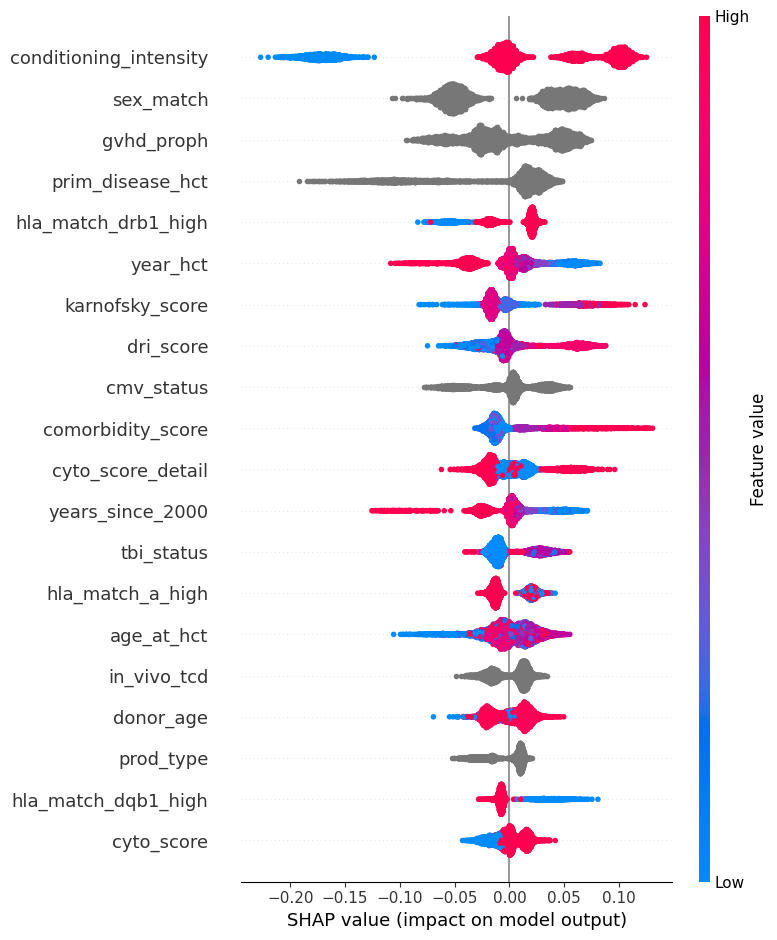

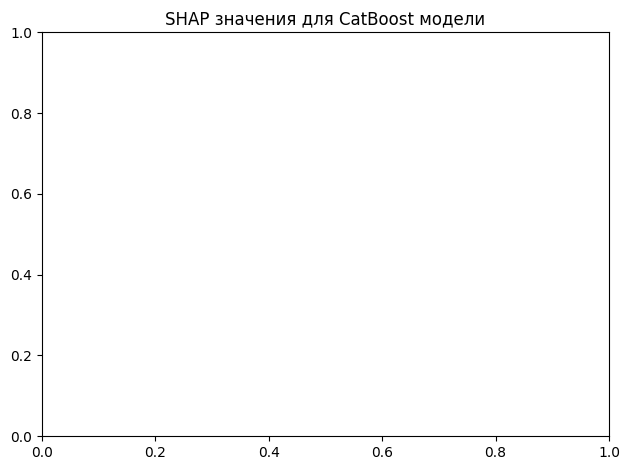

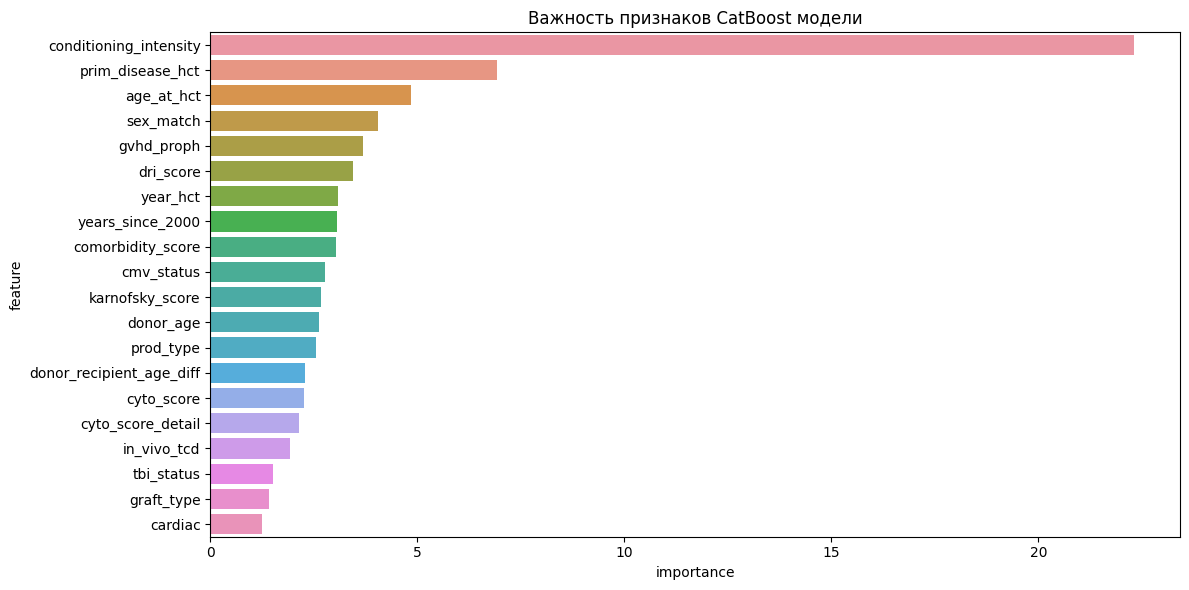

NameError: name 'mean_absolute_error' is not defined

In [28]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# SHAP анализ для CatBoost
def analyze_catboost_model(model, X_test, feature_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    # SHAP summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)
    plt.title('SHAP значения для CatBoost модели')
    plt.tight_layout()
    plt.show()
    
    # Feature Importance plot
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
    plt.title('Важность признаков CatBoost модели')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# Анализ метрик для всех моделей
def plot_model_metrics(predictions_dict, y_true):
    metrics = {}
    for model_name, preds in predictions_dict.items():
        mae = mean_absolute_error(y_true, preds)
        rmse = np.sqrt(mean_squared_error(y_true, preds))
        r2 = r2_score(y_true, preds)
        
        metrics[model_name] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        }
    
    # Визуализация метрик
    metrics_df = pd.DataFrame(metrics).T
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, metric in enumerate(['MAE', 'RMSE', 'R2']):
        sns.barplot(data=metrics_df.reset_index(), x='index', y=metric, ax=axes[i])
        axes[i].set_title(f'{metric} по моделям')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return metrics_df

# Использование функций
# Для одного фолда (для примера)
train_idx, val_idx = next(kf.split(train_data))
X_train = train_data.iloc[train_idx][features]
X_valid = train_data.iloc[val_idx][features]
y_train = train_data.iloc[train_idx][target]
y_valid = train_data.iloc[val_idx][target]

# Обучение CatBoost модели
cat_model = CatBoostRegressor(**cat_params, cat_features=cat_features, verbose=100)
cat_model.fit(
    Pool(X_train, y_train, cat_features=cat_features),
    eval_set=Pool(X_valid, y_valid, cat_features=cat_features),
    early_stopping_rounds=50
)

# Анализ CatBoost модели
feature_importance = analyze_catboost_model(cat_model, X_valid, features)

# Сравнение метрик всех моделей
predictions = {
    'CatBoost': cat_model.predict(X_valid),
    'XGBoost': xgb_model.predict(X_valid_enc),
    'LightGBM (GBDT)': lgb_model1.predict(X_valid_enc),
    'LightGBM (DART)': lgb_model2.predict(X_valid_enc)
}

metrics_comparison = plot_model_metrics(predictions, y_valid)

# Future Importance